In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!unzip ndvi_seg_mask_thresh_10.zip

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [ ]:
import cv2
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

def refine_segmentation(image, prob_map):
    """
    Refine segmentation masks using DenseCRF.

    Args:
    image (np.array): Original image of shape (H, W, 3).
    prob_map (np.array): Probability map of shape (num_classes, H, W).

    Returns:
    np.array: Refined segmentation mask of shape (H, W).
    """
    h, w = image.shape[:2]
    num_classes = prob_map.shape[0]

    # Ensure prob_map is C-contiguous
    prob_map = np.ascontiguousarray(prob_map)

    # Initialize CRF
    d = dcrf.DenseCRF2D(w, h, num_classes)

    # Get unary potentials (negative log probability maps)
    U = unary_from_softmax(prob_map)
    d.setUnaryEnergy(U)

    # Add pairwise Gaussian potential
    pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=(w, h))
    d.addPairwiseEnergy(pairwise_gaussian, compat=3)

    # Add pairwise bilateral potential
    pairwise_bilateral = create_pairwise_bilateral(sdims=(120, 120), schan=(13, 13, 13), img=image, chdim=2)
    d.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Perform inference
    Q = d.inference(5)

    # Get refined segmentation map
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))

    return refined_mask

In [ ]:
def get_refined_segmentations(folder_path, output_folder):

  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    os.makedirs(os.path.join(output_folder,'crf'))
    os.makedirs(os.path.join(output_folder,'crf_filter'))

  images_list = os.listdir(folder_path)
  for image_name in images_list:
    image_path = os.path.join(folder_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image[:,:512,:].copy()
    mask = image[:,512:,:1].copy()/255
    inverted_mask = 1 - mask
    prob_map = np.stack((inverted_mask[:,:,0], mask[:,:,0]), axis=2)
    prob_map = prob_map.transpose(2, 0, 1)
    refined_mask = refine_segmentation(original_image, prob_map)
    refined_mask = refined_mask.astype(np.uint8) * 255
    refined_mask_rgb = np.stack((refined_mask,refined_mask,refined_mask), axis = -1)

    contours, _ = cv2.findContours(refined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(refined_mask.shape, dtype=np.uint8)
    min_area = 500
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            mask = cv2.drawContours(mask, [contour], -1, 255, -1)
    filtered_mask = cv2.bitwise_and(refined_mask, refined_mask, mask=mask)
    # filtered_mask = filtered_mask.astype(np.uint8) * 255
    filtered_mask_rgb = np.stack((filtered_mask,filtered_mask,filtered_mask), axis = -1)
    # print(filtered_mask_rgb.shape, filtered_mask_rgb.max())
    crf_result_image = np.concatenate((image, refined_mask_rgb), axis=1)
    crf_filter_result_image = np.concatenate((image, refined_mask_rgb, filtered_mask_rgb), axis=1)
    output_image_path = os.path.join(output_folder, 'crf' , image_name)
    cv2.imwrite(output_image_path, cv2.cvtColor(crf_result_image, cv2.COLOR_BGR2RGB))
    output_image_path = os.path.join(output_folder, 'crf_filter' , image_name)
    cv2.imwrite(output_image_path, cv2.cvtColor(crf_filter_result_image, cv2.COLOR_BGR2RGB))

In [ ]:
!rm -rf thresh_15_refined

In [ ]:
output_folder = 'thresh_15_refined'
get_refined_segmentations('thresh_15', output_folder)

In [ ]:
!zip -r thresh_15_refined.zip thresh_15_refined

In [ ]:
image = cv2.imread('thresh_15/DATA_Corn_2023-12-20_CornRow2_10_Image_000086.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = image[:,:512,:].copy()
mask = image[:,512:,:1].copy()/255
inverted_mask = 1 - mask
prob_map = np.stack((inverted_mask[:,:,0], mask[:,:,0]), axis=2)
prob_map = prob_map.transpose(2, 0, 1)
refined_mask = refine_segmentation(original_image, prob_map)
refined_mask = refined_mask.astype(np.uint8) * 255
refined_mask_rgb = np.stack((refined_mask,refined_mask,refined_mask), axis = -1)
contours, _ = cv2.findContours(refined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(refined_mask.shape, dtype=np.uint8)

min_area = 500
for contour in contours:
    if cv2.contourArea(contour) > min_area:
        cv2.drawContours(mask, [contour], -1, 255, -1)

# # Resulting image with only larger objects
filtered_mask = cv2.bitwise_and(refined_mask, refined_mask, mask=mask)
# filtered_mask = filtered_mask.astype(np.uint8) * 255
filtered_mask_rgb = np.stack((filtered_mask,filtered_mask,filtered_mask), axis = -1)
result_image = np.concatenate((image, refined_mask_rgb, filtered_mask_rgb), axis=1)

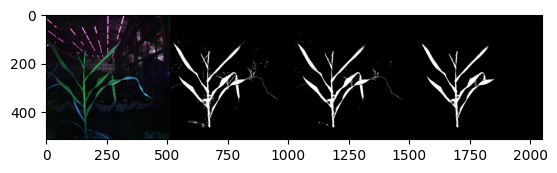

In [ ]:
plt.imshow(result_image)
plt.show()